In [1]:
### this notebook to be run in the fashion_MNIST environment
### requires tensorflow, keras, opencv

In [1]:
import keras
import tensorflow as tf
from keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, History
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
#from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers, optimizers, Model

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import random

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10724042142401297514
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6692228956
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17654250952366628353
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
num_classes = 10
batch_size = 256
img_rows, img_cols = 28, 28

In [3]:
# Load and transform data
mnist_data = fashion_mnist.load_data()
x = mnist_data[0][0]
y = mnist_data[0][1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .33, random_state = 41)

# reshape for NN tensors\
if K.image_data_format() == "channels first":
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# cast to a 32 bit float and then scale so the value is a float between 0 and 1
x_train = x_train.astype("float32") / 225
x_test = x_test.astype("float32") / 225

# convert class vector to binary class matrices (one hot encode)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_test shape: {}'.format(str(y_test.shape)))

# function to devoce one-hot-encoding later on when we want to evaluate performance
def decode_one_hot(y):
    y_classes = [np.argmax(yi, axis = None, out = None) for yi in y]
    return y_classes

y_test shape: (19800, 10)


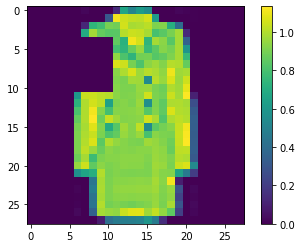

In [4]:
# data exploration
n = random.randint(0, x_train.shape[0] - 1)

def random_block(input_matrix):
    '''
    input matrix is expected to be (28, 28, 1)
    '''
    size = input_matrix.shape
    w = size[0] // 4
    h = size[1] // 4
    c = 0
    loc = (random.randint(0 + w // 2, size[0] - w - w // 2),
           random.randint(0 + h // 2, size[1] - h - h // 2))
    
    input_matrix_copy = input_matrix.copy()
    
    for i in range(w):
        for j in range(h):
            input_matrix_copy[loc[0] + i, loc[1] + j, 0] = c

            j+=1
        i+=1

    return input_matrix_copy

plt.figure()
#plt.imshow(x_train[n][:,:].reshape(28,28)) # reshape just gets rid of the extra dim (28,28,1)
plt.imshow(random_block(x_train[n][:,:]).reshape(28,28))
plt.colorbar()
plt.grid(False)

In [5]:
# set up image data generator
datagen = ImageDataGenerator(rotation_range = 0,
                            horizontal_flip = False,
                            fill_mode = 'constant',
                            cval = 0,
                            width_shift_range = 2,
                            height_shift_range = 2,
                            zoom_range = 2,
                            preprocessing_function = random_block)
datagen.fit(x_train)

In [6]:
# set up training function
def train(augmentation, epochs):
    '''
    This function is used to train the model and print out stats.
    Model must be compiled first.
    my_callbacks must be defined first.
    '''
    if not augmentation:
        print('NOT using image augmentation')
        hist = model.fit(x_train, y_train,
                        batch_size = batch_size,
                        epochs = epochs,
                        verbose = 1,
                        validation_data = (x_test, y_test),
                        callbacks=my_callbacks)
        
    else:
        print('using image augmentation')
        hist = model.fit_generator(datagen.flow(x_train, y_train,
                                                batch_size = batch_size),
                                   steps_per_epoch = len(x_train)/batch_size,
                                   validation_data = (x_test, y_test),
                                   epochs = epochs,
                                   verbose = 1,
                                   callbacks = my_callbacks,
                                   workers = 1)
    
    score = model.evaluate(x_test, y_test, verbose = 0)
    #yhat = model.predict_classes(x_test).astype(int)
    yhat = np.argmax(model.predict(x_test), axis = 1).astype(int)
    y_dec = decode_one_hot(y_test)
    
    print(metrics.classification_report(y_dec, yhat))
    print('Testing Loss: {}'.format(score[0]))
    print('Testing Accuracy: {}'.format(score[1]))
    print(model.summary())
    
    return hist

In [8]:
def plot_results(hist):
    epoch_list = list(range(1, len(hist.history['accuracy']) + 1))
    plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
    plt.legend(("Training Accuracy", "Validation Accuracy"))
    plt.show()

    plt.plot(epoch_list, hist.history['loss'], epoch_list, hist.history['val_loss'])
    plt.legend(("Training Loss", "Validation Loss"))
    plt.show()

In [26]:
# baseline model

model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape))
model.add(Dropout(0.1))
model.add(Activation('tanh'))

model.add(Conv2D(64, kernel_size=(3,3)))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('tanh'))

model.add(Flatten())
model.add(Dense(100)) # Try removing or adding this layer to improve performance
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))

optimizer = optimizers.Adam(learning_rate=1e-3)

# Having trouble getting tensorboard callback to work well with EarlyStopping callback...
model.compile(optimizer,
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ['accuracy'])

my_callbacks = [ModelCheckpoint('baseline.hdf5', monitor='accuracy', save_best_only=True, save_freq=1)]

In [9]:
import imp
import wrn
imp.reload(wrn)
model = wrn.WideResidualNetwork(input_shape = (28,28,1))

In [10]:
model.summary()

Model: "wide-resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 16)   0           batch_normalization[0][0]        
________________________________________________________________________________________

In [20]:
optimizer = optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer,
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ['accuracy'])
my_callbacks = [ModelCheckpoint('WRN_overfit.hdf5', monitor='accuracy', save_best_only=True, save_freq=1)]
model.load_weights('WRN.hdf5')

NOT using image augmentation
Train on 40200 samples, validate on 19800 samples
Epoch 1/25
40200/40200 [==============================] - 78s 2ms/sample - loss: 0.0792 - accuracy: 0.9729 - val_loss: 0.1711 - val_accuracy: 0.9434
Epoch 2/25
40200/40200 [==============================] - 72s 2ms/sample - loss: 0.0664 - accuracy: 0.9792 - val_loss: 0.1663 - val_accuracy: 0.9452
Epoch 3/25
40200/40200 [==============================] - 71s 2ms/sample - loss: 0.0598 - accuracy: 0.9808 - val_loss: 0.1644 - val_accuracy: 0.9457
Epoch 4/25
40200/40200 [==============================] - 72s 2ms/sample - loss: 0.0560 - accuracy: 0.9824 - val_loss: 0.1630 - val_accuracy: 0.9464
Epoch 5/25
40200/40200 [==============================] - 72s 2ms/sample - loss: 0.0525 - accuracy: 0.9841 - val_loss: 0.1622 - val_accuracy: 0.9468
Epoch 6/25
40200/40200 [==============================] - 72s 2ms/sample - loss: 0.0501 - accuracy: 0.9844 - val_loss: 0.1618 - val_accuracy: 0.9472
Epoch 7/25
40200/40200 [===

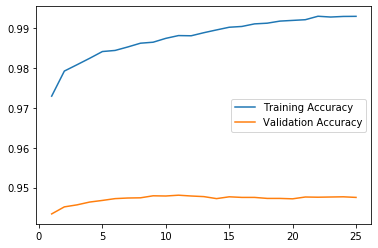

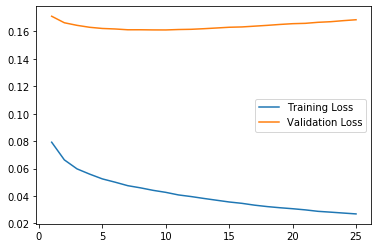

In [21]:
# Fit and evaluate model
hist = train(False, 25)
plot_results(hist)

In [17]:
model.save_weights('WRN.hdf5')

In [19]:
hist.params

{'batch_size': None,
 'epochs': 10,
 'steps': 157.03125,
 'samples': 157.03125,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

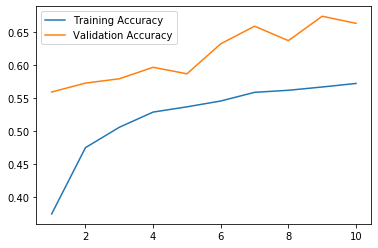

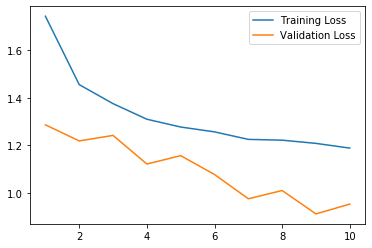

In [23]:
plot_results(hist)